In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import matplotlib.pyplot as plt 

%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

start = datetime.datetime(1989, 1, 1)
end = datetime.datetime(2019, 1, 1)

In [56]:
def cagr(df):
    delta = df.index[-1].year - df.index[0].year
    return (df.loc[df.index[-1], "Adj Close"] / df.loc[df.index[0], "Adj Close"]) ** (1/delta) - 1

def drawdown(df):
    cum_returns = (1 + df["Adj Close"].pct_change(1)).cumprod()
    return (cum_returns.div(cum_returns.cummax()) - 1) * 100

def sharpe(df):
    pct_change = df["Adj Close"].pct_change(1)
    return pct_change.mean() / pct_change.std() * (252 ** 0.5)

def sim_leverage(df, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = df["Adj Close"].pct_change(1)
    sim = pd.DataFrame().reindex_like(df)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim["Adj Close"] = (1 + pct_change).cumprod() * initial_value
    sim.loc[sim.index[0], "Adj Close"] = initial_value
    return sim

def visualize(df, title=""):
    dd = drawdown(df)
    print("CAGR: ", cagr(df))
    print("Sharpe: ", sharpe(df))
    print("Max Drawdown: ", dd.min())
    fig, axs = plt.subplots(2,1)
    df['Adj Close'].plot(ax=axs[0],title=title).set_ylabel("Value")
    dd.plot.area(ax=axs[1],color='red').set_ylabel("Drawdown pct.")


In [57]:
vfinx = web.DataReader("VFINX", "yahoo", start, end)
vusxt = web.DataReader("VUSTX", "yahoo", start, end)
upro = web.DataReader("UPRO", "yahoo", start, end)
tmf = web.DataReader("TMF", "yahoo", start, end)

CAGRs: 0.30860840636048303 0.30265730855633177


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-06-25,NaN,NaN,NaN,NaN,NaN,2.362003
2009-06-26,NaN,NaN,NaN,NaN,NaN,2.352548
2009-06-29,NaN,NaN,NaN,NaN,NaN,2.415634
2009-06-30,NaN,NaN,NaN,NaN,NaN,2.354300
2009-07-01,NaN,NaN,NaN,NaN,NaN,2.385721


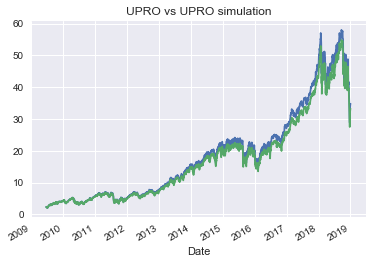

In [58]:
upro_sim = sim_leverage(
               vfinx.iloc[-len(upro):], 
               leverage=3.0, 
               expense_ratio=0.0092, 
               initial_value=upro.loc[upro.index[0], "Adj Close"]
           )
upro["Adj Close"].plot()
upro_sim["Adj Close"].plot(title="UPRO vs UPRO simulation")
print("CAGRs:", cagr(upro), cagr(upro_sim))
upro_sim.head()

CAGRs: 0.05287878988470385 0.0657378108447293


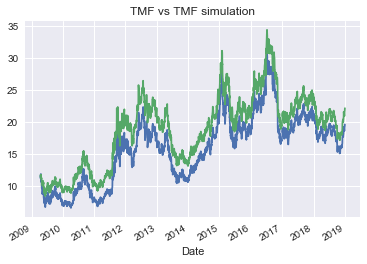

In [59]:
tmf_sim = sim_leverage(
               vusxt.iloc[-len(tmf):], 
               leverage=3, 
               expense_ratio=0.0111, 
               initial_value=tmf.loc[tmf.index[0], "Adj Close"]
           )
tmf["Adj Close"].plot()
tmf_sim["Adj Close"].plot(title="TMF vs TMF simulation")
print("CAGRs:", cagr(tmf), cagr(tmf_sim))

In [53]:
from scipy.stats import ranksums
ranksums(upro_sim["Adj Close"].pct_change(1), upro["Adj Close"].pct_change(1))

RanksumsResult(statistic=-0.03926743250242287, pvalue=0.9686771716787294)

In [54]:
ranksums(tmf_sim["Adj Close"].pct_change(1), tmf["Adj Close"].pct_change(1))

RanksumsResult(statistic=-0.20752500253386216, pvalue=0.8355998684643346)

CAGR:  0.17700599769184233
Sharpe:  0.5751450283026295
Max Drawdown:  -97.11177243366448


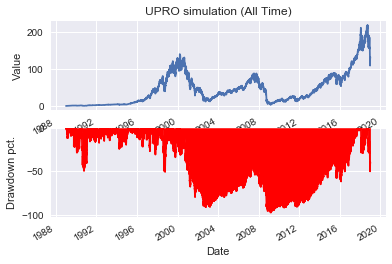

In [55]:
upro_sim = sim_leverage(
               vfinx, 
               leverage=3.0, 
               expense_ratio=0.0092,
           )

visualize(upro_sim, title="UPRO simulation (All Time)")

CAGR:  0.16837974934777256
Sharpe:  0.6542091691060772
Max Drawdown:  -50.311075565751636


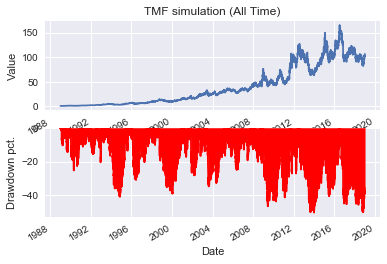

In [7]:
tmf_sim = sim_leverage(
               vusxt, 
               leverage=3.0, 
               expense_ratio=0.0111,
           )
visualize(tmf_sim, title="TMF simulation (All Time)")

CAGR:  0.23923955405138408
Sharpe:  0.9156709974837748
Max Drawdown:  -63.803172968538526


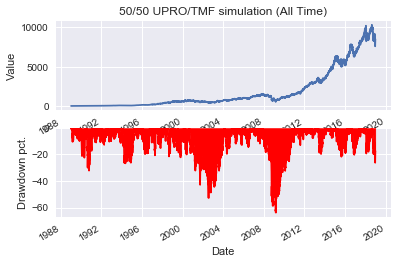

In [8]:
init = vfinx.loc[vfinx.index[0], "Adj Close"]
portfolio = pd.DataFrame().reindex_like(tmf_sim)
portfolio["Pct Change"] = .5 * tmf_sim["Pct Change"] + .5 * upro_sim["Pct Change"]
portfolio["Adj Close"] = cum_returns = (1 + portfolio["Pct Change"]).cumprod() * init
portfolio.loc[portfolio.index[0], "Adj Close"] = init
visualize(portfolio, title="50/50 UPRO/TMF simulation (All Time)")

(35, 0.9754915895070022)

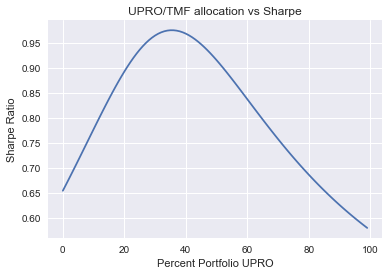

In [11]:
data = {}
for perc in range(100):
    daily = (1 - perc / 100) * tmf_sim["Pct Change"] + (perc / 100) * upro_sim["Pct Change"]
    data[perc] = daily.mean() / daily.std() * (252 ** 0.5)
    
s = pd.Series(data)
ax = s.plot(title="UPRO/TMF allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio UPRO")
s.idxmax(), s.max()

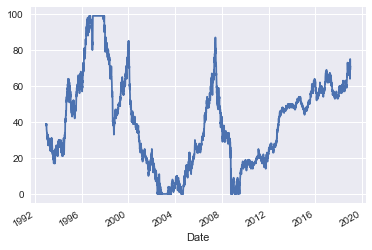

In [56]:
def rolling_sharpe():
    for perc in range(100):
        daily = (1 - perc / 100) * tmf_sim["Pct Change"] + (perc / 100) * upro_sim["Pct Change"]
        s = daily.rolling(1000).mean() / daily.rolling(1000).std() * (252 ** 0.5)
        s = s.rename(perc)
        yield s
        
df = pd.concat([s for s in rolling_sharpe()], axis=1)
maxs = df.idxmax(axis=1)
maxs.plot()

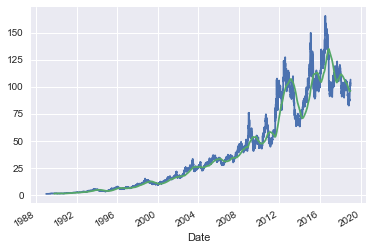

In [59]:
tmf_sim["200MA"] = tmf_sim["Adj Close"].rolling(200).mean()
tmf_sim["Adj Close"].plot()
tmf_sim["200MA"].plot()

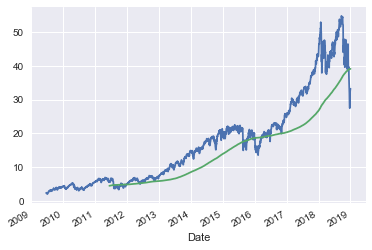

In [65]:
upro_sim["500MA"] = upro_sim["Adj Close"].rolling(500).mean()
upro_sim["Adj Close"].plot()
upro_sim["500MA"].plot()

In [69]:
import numpy as np
diff = upro_sim["500MA"] < upro_sim["Adj Close"]
diff_forward = diff.shift(1)
crossing = np.where(abs(diff - diff_forward) == 1)[0]
upro_sim.iloc[crossing]

,High,Low,Open,Close,Volume,Adj Close,Pct Change,500MA
Date,,,,,,,,
2011-06-17,NaN,NaN,NaN,NaN,NaN,5.603242,0.009103,4.457566
2011-08-04,NaN,NaN,NaN,NaN,NaN,4.635710,-0.143335,4.687626
2011-10-24,NaN,NaN,NaN,NaN,NaN,4.886018,0.038520,4.770108
2011-10-25,NaN,NaN,NaN,NaN,NaN,4.591382,-0.060302,4.772717
2011-10-27,NaN,NaN,NaN,NaN,NaN,5.223877,0.103122,4.779188
2011-11-01,NaN,NaN,NaN,NaN,NaN,4.434947,-0.083711,4.787030
2011-11-03,NaN,NaN,NaN,NaN,NaN,4.913493,0.056658,4.790735
2011-11-09,NaN,NaN,NaN,NaN,NaN,4.533309,-0.109918,4.798256
2011-11-11,NaN,NaN,NaN,NaN,NaN,4.922936,0.058355,4.801250
